In [1]:
!pip install colour-science

In [2]:
!pip install webcolors==1.11.0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import colour
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution
from matplotlib import colormaps as cm
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection  # Импортируем правильный класс

In [4]:
import webcolors

In [5]:
import colour
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution

In [6]:
def from_freq_to_len(data):
    # специально для файла, поэтому учитываем что частота в терагерцах
    # 3 * 1e8 / (np.asarray(data) * 1e12) * 1e9
    return list(3 * 1e5 / np.asarray(data))

In [7]:
# вводные данные
fn = "RCS_spectrum.txt"
# словарь:
#   ключ - радиус частицы в нм
#   значение - кортеж (длины волн, интенсивность?)
total_result = {}
# список с частотами, терагерцы
freqs = []
# список с интенсивностью
i_data = []
# радиус наночастиц
r_data = [70, 50, 54, 58, 62, 66][::-1]

# считываю спектр рассеяния
# здесь хитрое заполнение словаря - можно не вникать
with open(fn) as file:
    for line in file.readlines()[3:]:
        if "#" in line:
            if "Parameters" in line:
                total_result[r_data.pop()] = (from_freq_to_len(freqs), i_data)
                freqs, i_data = [], []

        else:
            f_l, i_v = line.split()
            freqs.append(float(f_l))
            i_data.append(float(i_v))

In [8]:
# проверяю сохраненные значения
total_result.keys()

dict_keys([70, 50, 54, 58, 62, 66])

In [9]:
print("Длины волн:", len(total_result[70][0]))
print("Значения RCS:", len(total_result[70][1]))

Длины волн: 134
Значения RCS: 134


Тут парный кодинг с DeepSeek

In [10]:
def show_rcs(req_R):
    # достаю из словаря данные для частицы радиусом R нанометров
    wavelengths, rcs_values = map(np.array, total_result[req_R])
    # здесь необычный способ нормализации от нейросетки
    rcs_normalized = (rcs_values - np.min(rcs_values)) / (np.max(rcs_values) - np.min(rcs_values))
    # Получение цветов из цветового пространства CIE
    cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Создание спектрального распределения для RCS (сворачиваем данные в удобную структуру)
    sd = colour.SpectralDistribution(
        dict(zip(wavelengths, rcs_normalized)),
        name=f"RCS (R={str(req_R)})"
    )

    # Визуализация RCS в зависимости от длины волны
    plt.figure(figsize=(12, 6))
    colour.plotting.plot_single_sd(
        sd,
        cmfs=cmfs,
        y_label="Normalized RCS",
        title=f"Radar Cross-Section (R={str(req_R)} nm)"
    )

<Figure size 1200x600 with 0 Axes>

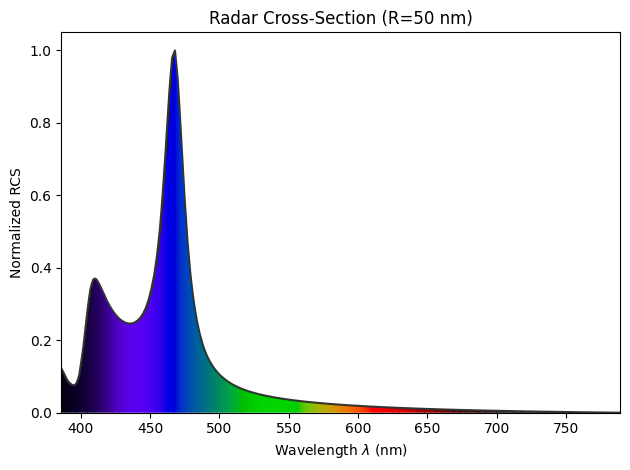

In [11]:
show_rcs(50)

In [12]:
def get_data(req_R):
    wavelengths, rcs_values = map(np.array, total_result[req_R])
    wavelengths_resampled = np.arange(380, 790, 5)  # 380-780nm in 5nm steps
    # здесь указание, как заполнить значения
    interpolator = interp1d(wavelengths, rcs_values, kind='linear', fill_value='extrapolate')
    rcs_resampled = interpolator(wavelengths_resampled)
    # приводим к необходимому представлению
    sd = SpectralDistribution(dict(zip(wavelengths_resampled, rcs_resampled)), name=f"RCS (R={req_R})")

    # источник света 380 - 780 нм
    illuminant = colour.SDS_ILLUMINANTS["D65"]
    # Получение цветов из цветового пространства CIE
    cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Преобразование RCS в цвет (используя XYZ)
    xyz = colour.sd_to_XYZ(sd, cmfs, illuminant)
    xy = colour.XYZ_to_xy(xyz)

    return xy

In [13]:
get_data(50)

array([ 0.1622292 ,  0.10914458])

In [14]:
get_data(54)

array([ 0.15532787,  0.1914908 ])

In [15]:
get_data(58)

array([ 0.16097508,  0.30059609])

In [16]:
def convert_cie_to_rgb(xy_arr, bit_form=False, Y=0.5):
    x, y = xy_arr

    # Нормализация яркости с сохранением цветового тона
    xyY = np.array([x, y, Y])

    try:
        # Преобразование с проверкой цветового охвата
        XYZ = colour.xyY_to_XYZ(xyY)

        # Автоматическая коррекция яркости перед преобразованием
        XYZ_normalized = XYZ / max(XYZ) * Y * 1.2

        # Альтернативное преобразование с использованием разных методов
        RGB = colour.XYZ_to_sRGB(
            XYZ_normalized,
            illuminant=colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65'],
            chromatic_adaptation_transform='CAT02'
        )

        # Улучшенная обработка выхода за пределы охвата
        RGB_clipped = colour.utilities.orient(RGB, 'Ignore')

        # Альтернативная гамма-коррекция для лучшего восприятия
        RGB_gamma_corrected = colour.models.cctf_encoding(
            RGB_clipped,
            function='sRGB'
        )

        # Дополнительная коррекция для сохранения различий
        if np.max(RGB_gamma_corrected) - np.min(RGB_gamma_corrected) < 0.15:
            RGB_gamma_corrected = colour.utilities.lerp(
                RGB_gamma_corrected,
                np.mean(RGB_gamma_corrected),
                0.3
            )

        if bit_form:
            return (RGB_gamma_corrected * 255).astype(np.uint8)

        return np.clip(RGB_gamma_corrected, 0.0, 1.0)

    except ValueError as e:
        print(f"Ошибка преобразования: {e}")
        return np.zeros(3) if not bit_form else np.zeros(3, dtype=np.uint8)

In [17]:
convert_cie_to_rgb(get_data(50))

array([ 0.        ,  0.56639805,  0.9120091 ])

In [18]:
def show_cie(req_Rs):

    xs = []
    ys = []
    labels = []
    cur_cmap = cm['gray_r']
    colors = cur_cmap(np.linspace(0.5, 1, len(req_Rs)))

    for req_R in req_Rs:
        cur_xy = get_data(req_R)
        xs.append(cur_xy[0])
        ys.append(cur_xy[1])
        labels.append(f"R = {req_R} nm")

    colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

    size_step = 25
    sizes = range(size_step, size_step * len(req_Rs) + size_step, size_step)

    for i in range(len(xs)):
        plt.scatter(xs[i], ys[i], label=labels[i], s=sizes[i],
                    facecolor='none', linewidths=1.5,
                    edgecolors=colors[i])

    plt.title("CIE 1931 Chromaticity Diagram with RCS Color")
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


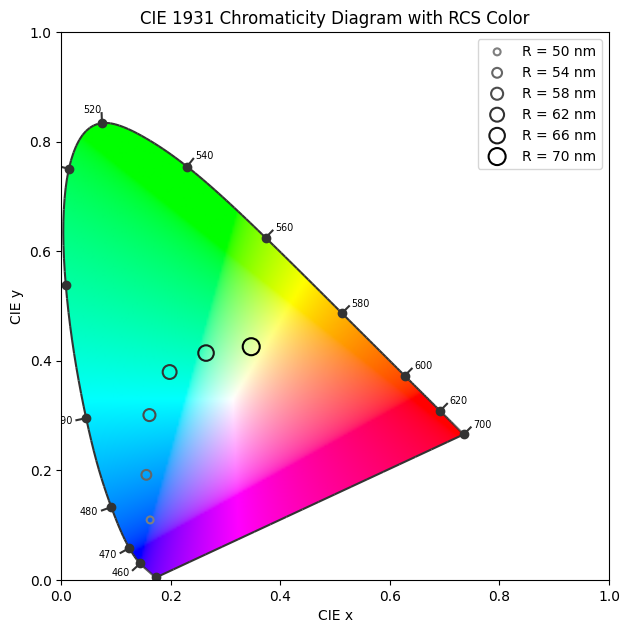

In [19]:
show_cie(range(50, 71, 4))

In [20]:
def get_rgb_list(cur_Rs, bit_form=False):
    answer = []
    for cur_R in cur_Rs:
        data = get_data(cur_R)
        rgb_val = convert_cie_to_rgb(data, bit_form)
        answer.append(rgb_val)
    return answer

In [21]:
get_rgb_list(range(50, 71, 4))

[array([ 0.        ,  0.56639805,  0.9120091 ]),
 array([ 0.        ,  0.73717498,  0.90705026]),
 array([ 0.        ,  0.86591715,  0.89790335]),
 array([ 0.        ,  0.94859387,  0.88661031]),
 array([ 0.60640236,  0.95138916,  0.83191181]),
 array([ 0.87407608,  0.92364318,  0.75575412])]

In [22]:
def rgb_to_color_name(rgb_tuple):
    try:
        return webcolors.rgb_to_name(rgb_tuple)
    except ValueError:
        return _find_closest_color(rgb_tuple)

In [23]:
def _find_closest_color(rgb):
    # Получаем все стандартные цвета CSS3
    css3_colors = webcolors.CSS3_HEX_TO_NAMES
    # Создаем словарь всех цветов (стандартные + кастомные)
    all_colors = {}

    # Добавляем стандартные цвета
    for hex_code, name in css3_colors.items():
        all_colors[name] = webcolors.hex_to_rgb(hex_code)

    # Поиск ближайшего цвета
    min_distance = float('inf')
    closest_name = "Неизвестный цвет"

    r, g, b = rgb
    target = np.array([r, g, b])

    for name, color in all_colors.items():
        color_array = np.array(color)
        distance = np.linalg.norm(target - color_array)

        if distance < min_distance:
            min_distance = distance
            closest_name = name

    return closest_name

In [53]:
# Задайте ваши RGB-цвета (значения от 0 до 255)
colors = [
    get_rgb_list(range(50, 59, 4), bit_form=True),
    get_rgb_list(range(62, 71, 4), bit_form=True)
]
color_array = [
    get_rgb_list(range(50, 59, 4)),
    get_rgb_list(range(62, 71, 4))
]

"""
names = [
    [rgb_to_color_name(el) for el in get_rgb_list(range(50, 59, 4), bit_form=True)],
    [rgb_to_color_name(el) for el in get_rgb_list(range(62, 71, 4), bit_form=True)]
]
"""

names = [
    ["васильковый", "морская волна", "светло-бирюзовый"],
    ["светлый циан", "аквамариновый", "светло-песочный"]
]


sizes = [
    list(range(50, 59, 4)),
    list(range(62, 71, 4))
]

In [42]:
print(colors)

[[array([ 69, 144, 232], dtype=uint8), array([ 46, 187, 231], dtype=uint8), array([ 76, 220, 228], dtype=uint8)], [array([254, 241, 226], dtype=uint8), array([154, 242, 212], dtype=uint8), array([222, 235, 192], dtype=uint8)]]


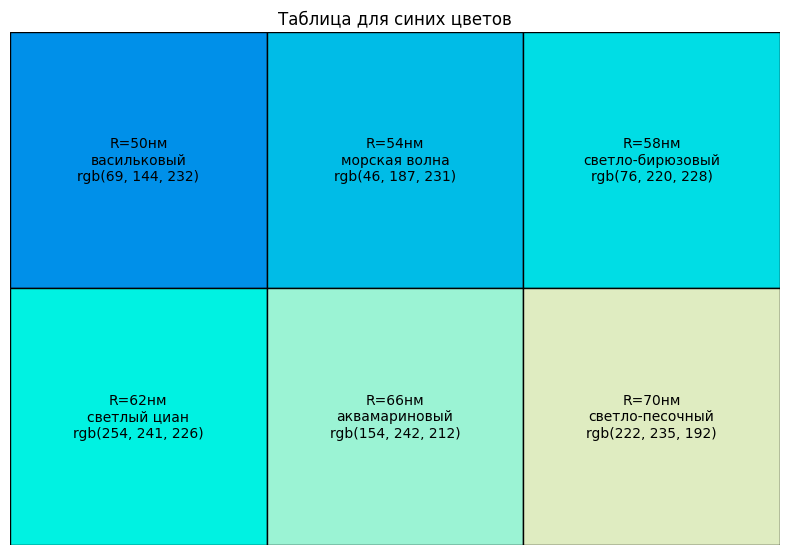

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')

# Отключаем оси
ax.axis('off')

# Создаем таблицу с цветными ячейками
for i in range(len(colors)):
    for j in range(len(colors[0])):
        # Рисуем цветной прямоугольник
        rect = plt.Rectangle((j, -i), 1, 1,
                            facecolor=color_array[i][j],
                            edgecolor='black')
        ax.add_patch(rect)

        # Добавляем текст с RGB-значениями
        rgb = colors[i][j]
        ax.text(j + 0.5, -i + 0.5,
               f'R={sizes[i][j]}нм\n{names[i][j]}\nrgb({", ".join(str(el) for el in rgb)})',
               ha='center', va='center',
               color="black",
               fontsize=10)

# Настройка границ
ax.set_xlim(0, len(colors[0]))
ax.set_ylim(-len(colors) + 1, 1)

plt.title('Таблица для синих цветов')
plt.tight_layout()
plt.show()

In [44]:
for color in get_rgb_list(range(50, 71, 4), bit_form=True):
    print(f"RGB {color} → {rgb_to_color_name(color)}")

RGB [ 69 144 232] → cornflowerblue
RGB [ 46 187 231] → mediumturquoise
RGB [ 76 220 228] → turquoise
RGB [254 241 226] → linen
RGB [154 242 212] → aquamarine
RGB [222 235 192] → palegoldenrod
